# [DataCamp Convolutional Neural Networks Tutorial](https://www.datacamp.com/tutorial/convolutional-neural-networks-python)



## Step 1: Load the data

In [43]:
from keras.datasets import fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

<font color='red'>Question: How does the function above differ from train_test_split? Is the test size of the data predetermined? </font>

Answer:

In [44]:
# Lets take a look at the shape of one observation from X_train:
train_X[0].shape

(28, 28)

In [45]:
train_X.shape

(60000, 28, 28)

In [46]:
train_Y.shape

(60000,)

In [47]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt

print("Training data shape : ", train_X.shape, train_Y.shape)
print("Testing data shape : ", test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


### Initial notes on the data:
- As expected, each observation is a 28x28 array!
- train_X contains 60,000 observations. Each one being a 28x28 array
- train_Y also contains an array with 60,000 labels. Each label is an integer that corresponds to the type of clothing that is represented in the corersponding training_X dataset.
- The test datasets contain 10,000 observations (X) and labels (Y)

### Label descriptions:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot


## Step 2: Analyze the Data

In [48]:
### Find the unique numbers from the train labels. In other words, the unique values that exist within train_Y

label_values = np.unique(train_Y)
num_labels = len(val_counts) 

print("The total number of output classes is ", num_labels)
print("The output values are ", label_values)


The total number of output classes is  10
The output values are  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : 9')

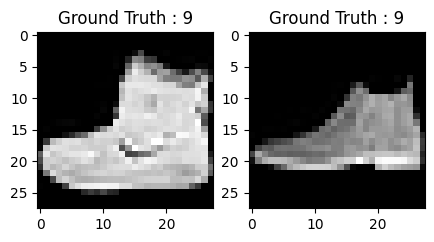

In [49]:
### Take a look at what the images in the dataset look like
plt.figure(figsize=[5,5])

# Display the first image in the training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap="gray")
plt.title(f"Ground Truth : {train_Y[0]}")

# Display the first image in the testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap="gray")
plt.title(f"Ground Truth : {test_Y[0]}")

## Step 3: Data Preprocessing

Because the images we are working with are 28x28 we need to preprocess the data before we feed it into the model. This is because .load_data() supplies the MNIST digits with the structure (num_samples, 28, 28) i.e. with two dimensions per example. This is the greyscale image that we see above.

The convolution2D layers in keras, however, are designed to work with 3 dimensions per example. They have four dimensional inputs and outputs. This covers colour images: 
- num_samples (argument -1 is used to automatically calculate the size of the first dimension based on the size of the other dimensions.
- width
- height
- num_channels (1 for grayscale images)

But, more importantly, it covers deeper layers of the network where each sample has become a set of feature maps:
- num_samples
- width
- height
- num_features

The reshape() function is used to change the shape of an array without changing its data. in this case the train_X and test_X arrays are being reshaped to have four dimensions


In [50]:
# Reshaping
train_X = train_X.reshape(-1, 28, 28, 1).astype("float32")
test_X = test_X.reshape(-1, 28, 28, 1).astype("float32")
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Note: because the data is in int8 format we will need to convert it's type (this is done with the astype() function above. This is because we will be wanting our model to generate prediction probabilities. In addition, we will be rescaling the pixel values to be within the range of 0 - 1 inclusive.

<font color='red'>Question: Why exactly do we need our data to be a float datatype when we are training a CNN that produces one hot encoded lables? </font>

Answer:

In [51]:
# Greyscale is a value between 0 (black) and 255 (white). Divide by 255 to scale our data so that the values are between 0 - 1
train_X = train_X / 255 
test_X = test_X/ 255

### One hot encoding 
Our next step is to convert the class labels (which are integer values from 0 - 9) into a one hot encoding vector

In [52]:
# Change the training and testing labels (Y) from categorical values into a one hot encoding vector:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [55]:
# Finally we are ready to make our train test split:

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=42, shuffle=True)

## Step 4: The Network

We will be using three convolutional layers and three max pooling layers:
1. 32-3 x 3 filters
(Max Pooling 2x2)
3. 64-3 X 3 filters
(Max Pooling 2x2)
5. 128-3 x 3 filters
(Max Pooling 2x2)

<img src="../fashion-mnist-architecture_htbpsz.webp.crdownload" alt="Alternative text" />

## Step 5: Model the Data

In [63]:
# importing all necessary modules for model training:

import keras
from keras.models import Sequential
# , Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU

Now we will define our batch size. This contributes massively to determining the learning parameters and affects the prediction accuracy. We will train the network for 20 epochs.

<font color='red'>Question: How do I choose batch size? How specifically does batch size impact network training and is choosing mostly done by trial and error? Also, what is learning rate and learning parameters? </font>


In [58]:
batch_size = 64
epochs = 20
num_classes = 10

## Step 6: Neural Network Architecture

In Keras, you can just stack up layers by adding the desired layer one by one. That's exactly what you'll do here: you'll first add a first convolutional layer with Conv2D(). Note that you use this function because you're working with images! Next, you add the Leaky ReLU activation function which helps the network learn non-linear decision boundaries. Since you have ten different classes, you'll need a non-linear decision boundary that could separate these ten classes which are not linearly separable.

More specifically, you add Leaky ReLUs because they attempt to fix the problem of dying Rectified Linear Units (ReLUs). The ReLU activation function is used a lot in neural network architectures and more specifically in convolutional networks, where it has proven to be more effective than the widely used logistic sigmoid function. As of 2017, this activation function is the most popular one for deep neural networks. The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope.

Next, you'll add the max-pooling layer with MaxPooling2D() and so on. The last layer is a Dense layer that has a softmax activation function with 10 units, which is needed for this multi-class classification problem.

<font color='red'>Question: Can I get an example of how ReLU units can die based on the gradients that pass through them and how a "leaky ReLU" helps to overcome this?</font>


In [64]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

## Step 7: Compile the Model

After the model is created, you compile it using the Adam optimizer, one of the most popular optimization algorithms. You can read more about this optimizer here. Additionally, you specify the loss type which is categorical cross entropy which is used for multi-class classification, you can also use binary cross-entropy as the loss function. Lastly, you specify the metrics as accuracy which you want to analyze while the model is training.

<font color='red'>Key terms and concepts to study: Adam optimizer, loss type, how to choose a metric for while the model is training, what is the difference between training accuracy and training loss?</font>

In [65]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [68]:
# Let's visualize the layers that you created in the above step by using the summary function. This will show some parameters (weights and biases) in each layer and also the total parameters in your model.

fashion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                   

## Step 8: Train the Model

It's finally time to train the model with Keras' fit() function! The model trains for 20 epochs. The fit() function will return a history object; By storying the result of this function in fashion_train, you can use it later to plot the accuracy and loss function plots between training and validation which will help you to analyze your model's performance visually.

In [70]:
fashion_train = fashion_model.fit(X_train, Y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, Y_test))

Epoch 1/20
750/750 [==============================] - 15s 20ms/step - loss: 0.4716 - accuracy: 0.8269 - val_loss: 0.3134 - val_accuracy: 0.8860
Epoch 2/20
750/750 [==============================] - 16s 22ms/step - loss: 0.2894 - accuracy: 0.8933 - val_loss: 0.2763 - val_accuracy: 0.8992
Epoch 3/20
750/750 [==============================] - 16s 22ms/step - loss: 0.2416 - accuracy: 0.9097 - val_loss: 0.2454 - val_accuracy: 0.9098
Epoch 4/20
750/750 [==============================] - 17s 22ms/step - loss: 0.2114 - accuracy: 0.9213 - val_loss: 0.2281 - val_accuracy: 0.9171
Epoch 5/20
750/750 [==============================] - 17s 22ms/step - loss: 0.1855 - accuracy: 0.9318 - val_loss: 0.2230 - val_accuracy: 0.9183
Epoch 6/20
750/750 [==============================] - 17s 22ms/step - loss: 0.1640 - accuracy: 0.9388 - val_loss: 0.2295 - val_accuracy: 0.9193
Epoch 7/20
750/750 [==============================] - 17s 22ms/step - loss: 0.1410 - accuracy: 0.9471 - val_loss: 0.2148 - val_accuracy:

## Step 9: Model Evaluation on the Test Set

In [71]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [72]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 0.4635132849216461
Test accuracy: 0.9174000024795532


In [74]:
fashion_train.history

{'loss': [0.47158193588256836,
  0.28936225175857544,
  0.24161745607852936,
  0.21142254769802094,
  0.18548907339572906,
  0.16397443413734436,
  0.14103762805461884,
  0.12208730727434158,
  0.10423383861780167,
  0.08779553323984146,
  0.0775630921125412,
  0.06639832258224487,
  0.0543961301445961,
  0.04795580729842186,
  0.045191746205091476,
  0.04391538351774216,
  0.0357174314558506,
  0.03382450342178345,
  0.03089768812060356,
  0.031020062044262886],
 'accuracy': [0.8269374966621399,
  0.8933125138282776,
  0.9097291827201843,
  0.9213125109672546,
  0.9318333268165588,
  0.9387916922569275,
  0.9470833539962769,
  0.9540208578109741,
  0.9604791402816772,
  0.9671875238418579,
  0.9705833196640015,
  0.9752708077430725,
  0.979854166507721,
  0.9815416932106018,
  0.9837499856948853,
  0.9837499856948853,
  0.9868958592414856,
  0.9876041412353516,
  0.9883333444595337,
  0.9886458516120911],
 'val_loss': [0.31341272592544556,
  0.2763347029685974,
  0.24536964297294617,


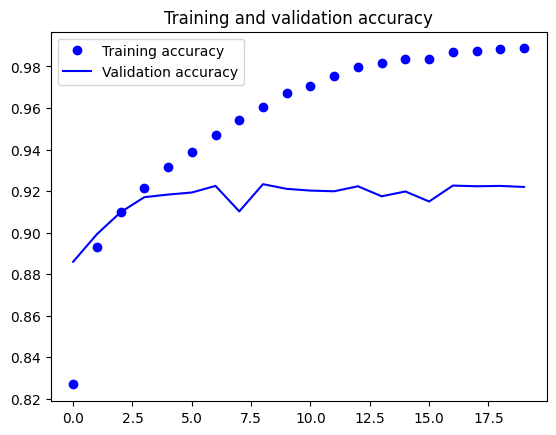

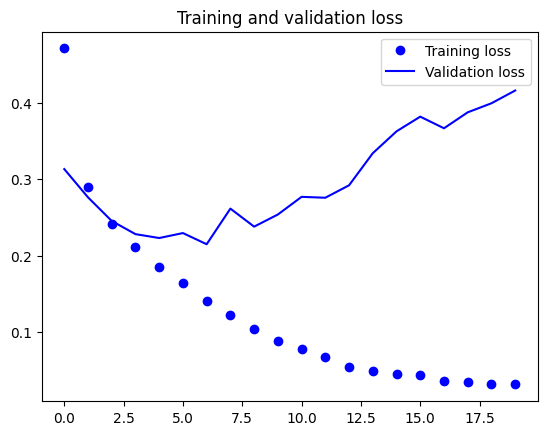

In [76]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Step 10: Adding Dropout into the Network

## Step 11: Model Evaluation on the Test Set, Take 2

## Step 12: Predict Labels

## Step 13: Classification Report